# Init

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rootutils
rootutils.setup_root('.', indicator=".project-root", pythonpath=True)

WindowsPath('E:/Projects/ActivityDiff')

In [3]:
import os
from pathlib import Path
from functools import partial

import numpy as np
from rdkit import Chem

from omegaconf import OmegaConf
from hydra import compose, initialize

import torch
from dgllife.model import MPNNPredictor

torch.set_grad_enabled(False)
torch.backends.cudnn.enabled = False  # cudnn RNN backward can only be called in training mode

from lcmg.models import LCMGModule
from lcmg.utils.run_utils import run
from lcmg.utils.visualization import mol2grid_img

In [5]:
config_path = os.path.relpath(Path(os.environ["PROJECT_ROOT"])/'configs')

with initialize(version_base="1.3", config_path=config_path):
    cfg = compose(config_name="train.yaml", overrides=["experiment=sd_mt_geom"])
# OmegaConf.resolve(cfg)

# cfg['data']['batch_size'] = 128

print(OmegaConf.to_yaml(cfg))

tags:
- opensource
- geom
- inference
model:
  _target_: lcmg.models.LCMGModule
  net:
    _target_: lcmg.nets.MGraphTransformer
    _partial_: true
    n_layers: 12
    n_heads: 4
    din_v: ???
    din_e: ???
    din_pos: ???
    din_g: ???
    dh_v: 128
    dh_e: 64
    dh_g: 128
    de_geo: 32
    norm: true
  fg_init_type: normed_snr
  fg_in_dim: 4
  snr_gamma: 5
  kekulize_sampling_test_mols: true
  train_dataset_info: ???
  num_diffusion_timesteps: 500
  diffusion_units:
    v_pos:
      _target_: lcmg.diffusion.ENNormalDiffusion
      _partial_: true
      betas:
        _target_: lcmg.diffusion.get_named_beta_schedule
        schedule_name: cosine
        num_diffusion_timesteps: ${....num_diffusion_timesteps}
        nu: 2.5
      model_pred_type: start_x
    v_atom_type:
      _target_: lcmg.diffusion.CategoricalDiffusion
      _partial_: true
      class_probs: ???
      betas:
        _target_: lcmg.diffusion.get_named_beta_schedule
        schedule_name: cosine
        nu

C:\Users\z\miniforge3\envs\lcmg\Lib\site-packages\hydra\_internal\defaults_list.py:251: UserWarning: In 'train.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


## load model checkpoints

In [6]:
module = LCMGModule.load_from_checkpoint(
    checkpoint_path=r'E:/Projects/lcmg/lt_logs/train/runs/sd_mt_geom_2024-07-17_23-45-05/checkpoints/epoch_064.ckpt')
module.to('cuda')
module.eval();

E:\Projects\ActivityDiff\lcmg\nets\layers\graph_layers.py:19: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## Gradient Scale Functions

In [7]:
def cos_fn(i,a=1,b=100,t=505):
    s = (np.cos(np.linspace(0,np.pi,t))+1)/2*(b-a)+a
    return s[t-i]

In [8]:
def lin_fn(i,a=1,b=100,t=505):
    s = np.linspace(b,a,t)
    return s[t-i]

In [32]:
def const_fn(i, a=100, b=100, t=505):
    return a

In [10]:
# import matplotlib.pyplot as plt
#
# plt.plot([lin_fn(i) for i in range(1,501)])

# Run

In [16]:
exp_configure = {
    'in_node_feats': 32,
    'in_edge_feats': 6,
    'node_out_feats': 64,
    'edge_hidden_feats': 128,
    'num_step_message_passing': 6,
    'num_step_set2set': 6,
    'num_layer_set2set': 3,
    'n_tasks': 1,
    "patience": 50
}

def get_cls_model(ckpt_path=None):
    cls_model = MPNNPredictor(
        node_in_feats=exp_configure['in_node_feats'],
        edge_in_feats=exp_configure['in_edge_feats'],
        node_out_feats=exp_configure['node_out_feats'],
        edge_hidden_feats=exp_configure['edge_hidden_feats'],
        num_step_message_passing=exp_configure['num_step_message_passing'],
        num_step_set2set=exp_configure['num_step_set2set'],
        num_layer_set2set=exp_configure['num_layer_set2set'],
        n_tasks=exp_configure['n_tasks']
    )

    if ckpt_path is not None:
        checkpoint = torch.load(ckpt_path, weights_only=True)
        cls_model.load_state_dict(checkpoint)
        cls_model = cls_model.to('cuda')

    return cls_model

In [11]:
fQ02750 = Chem.MolFromSmiles('OCC(O)CONC([*])=O')
fP15056 = Chem.MolFromSmiles('[*]NC(=O)NC1=CC=C([*])C=C1')

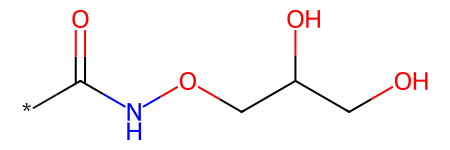

In [12]:
fQ02750

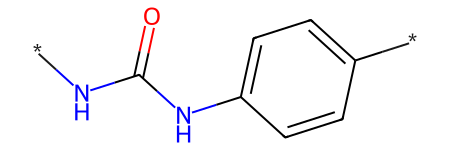

In [13]:
fP15056

In [35]:
cls_model_P15056 = get_cls_model(ckpt_path='P15056.pth')
cls_model_Q02750 = get_cls_model(ckpt_path='Q02750.pth')

In [36]:
lbd_fn = partial(const_fn, a=10)  # gradient scale function
# lbd_fn = partial(lin_fn, a=1, b=15)

# cls_models: a list of classifier identifiers (e.g., model names).
cls_models = [cls_model_Q02750]
# target_labels: a list of integers that specify the guidance direction for each corresponding model in cls_models. 1 for positive guidance and 0 for negative guidance
target_labels = [1]
# The two lists must have the same length; each label maps to the model at the same index.

fragment = fP15056 #  fP15056, fQ02750, or None

batch_size = 32

res = run(self=module, lbd_fn=lbd_fn, batch_size=batch_size,
          cls_models=cls_models, target_labels=target_labels, fragment=fragment)

  0%|          | 0/500 [00:00<?, ?it/s]

[rank: 0] defaultdict(<class 'int'>, {'AtomValenceException': 5, 'NotConnected': 3})


{'connectivity': 0.90625, 'validity': 0.84375, 'uniqueness': 1.0, 'score_0': 0.7242375016212463}


In [37]:
res['smiles'].__len__()

27

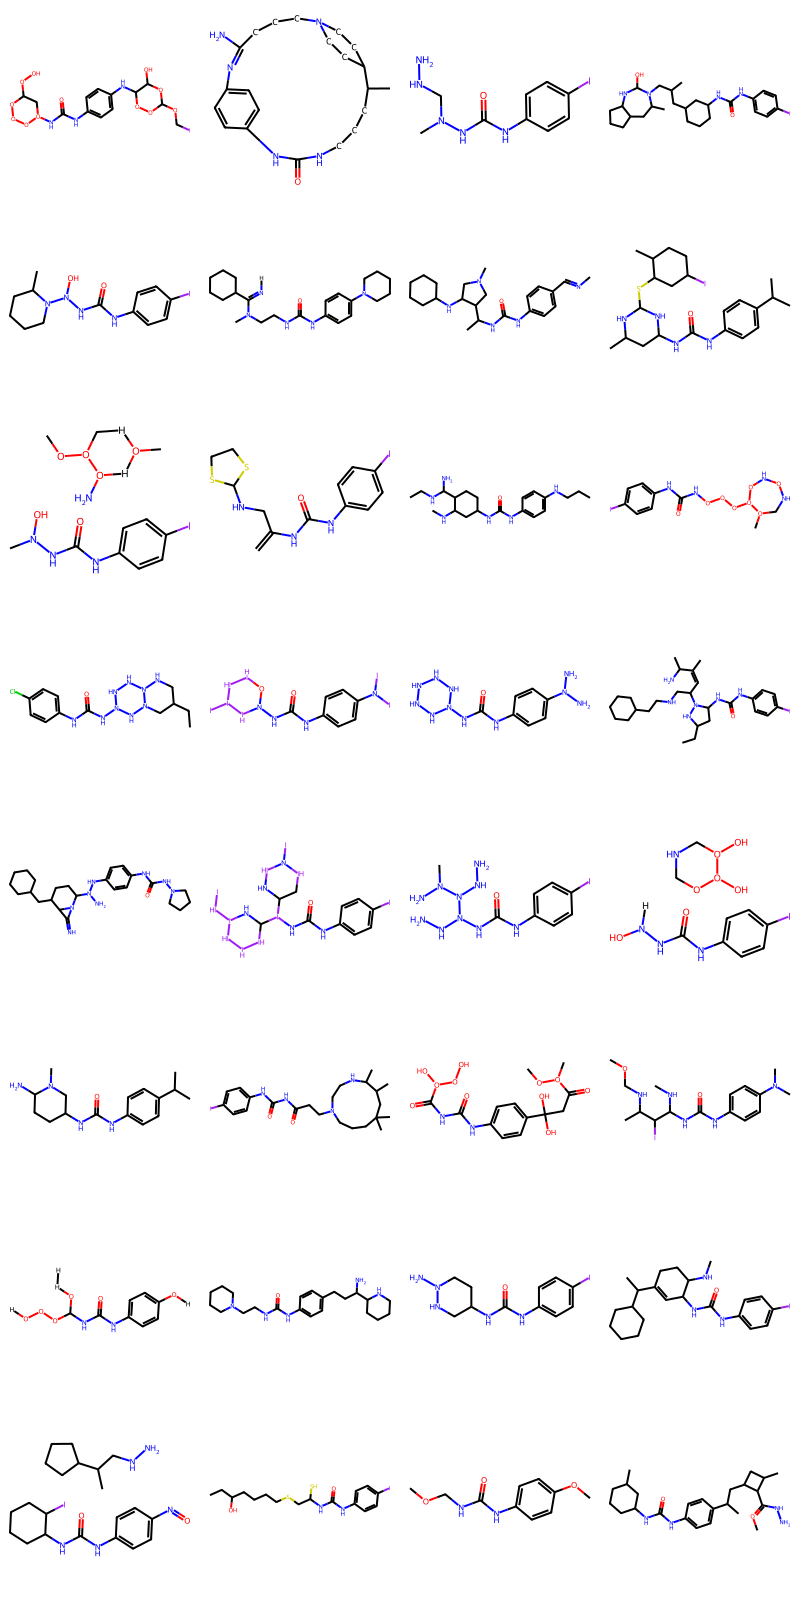

In [38]:
mol2grid_img(res['res_mols'], img_per_row=4)